<a href="https://colab.research.google.com/github/seonae0223/Deep_Learning/blob/main/05_%EC%B6%9C%EB%A0%A5%EC%B8%B5_%EC%84%A4%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망의 사용처
* 신경망은 분류, 회귀 모두 사용하다.
  * 출력층의 **활성화 함수**에 따라서 목적(사용처)이 달라진다. ( 분류를 할지, 회귀를 할지 )
  * 회귀에서는 항등 함수를 사용하면 회귀가 된다.
* 소프트맥스나 시그모이드 함수를 활용하면 분류
  * 시그모이드는 사용처가 정해져 있음
    * 결괏값을 **확률**로 표현하고 싶을 때 사용한다.
    * 예를 들면 89.12% 확률로 부정적인 리뷰 입니다.
  * 소프트맥스 함수를 주로 분류용 활성화 함수로 사용한다.

# 소프트맥스 함수 구현하기
$$
y_k = \frac{e^{z_k}}{\sum_{i=0}^{n-1} e^{z_i}}
$$

* $k$ : $k$번째 출력 ( 클래스 번호 ) 0, 1, 2 ....
* $z$ : 출력층에 있는 뉴런의 $WX+b$ 연산
* $n$ : 전체 클래스의 개수

In [1]:
import numpy as np

In [59]:
# 출력층의 WX+b를 z라고 가정
z = np.array([0.3, 2.9, 4.0])

# 분자 부분 계산
exp_z = np.exp(z)

# 분모 부분 계산
sum_exp_z = np.sum(exp_z)

pred_y = exp_z / sum_exp_z
pred_y # 소프트맥스 결과

array([0.01821127, 0.24519181, 0.73659691])

In [60]:
np.sum(pred_y)

1.0

# 소프트맥스 함수 튜닝
* 소프트맥스 함수는 자연상수 $e$의 지수 함수
* 입력값이 조금만 커져도 굉장히 큰 값을 연산을 한다.
* 예시
  * $e^{10}$만 되어도 20000이 넘는 수
  * $e^{100}$은 0이 40개가 넘는 큰 숫자
  * $e^{1000}$은 무한대를 의미하는 `inf`

In [61]:
def softmax(z):
  exp_z = np.exp(z) # 분자
  sum_exp_z = np.sum(exp_z) # 분모
  pred_y = exp_z / sum_exp_z
  return pred_y

In [62]:
big_z = [1000, 900, 1100]

softmax(big_z)

<ipython-input-61-b5ee1dba0da1>:2: RuntimeWarning: overflow encountered in exp
  exp_z = np.exp(z) # 분자
<ipython-input-61-b5ee1dba0da1>:4: RuntimeWarning: invalid value encountered in divide
  pred_y = exp_z / sum_exp_z


array([nan, nan, nan])

수학적인 기교로 튜닝이 가능하다.
$$
y_k = \frac{exp(a_k)}{\sum_{i=1}^n exp(a_i)} = \frac{C\,exp(a_k)}{C\,\sum_{i=1}^n exp(a_i)} = \frac{exp(a_k+logC)}{\sum_{i=1}^n exp(a_i+logC)} = \frac{exp(a_k+C^\prime)}{\sum_{i=1}^n exp(a_i+C^\prime)}
$$

In [63]:
# C^prime 이라는 상수는 보통 제일 큰 값에 -1을 곱한 값
# a_k가 각각의 원소

c = np.max(big_z)
big_z + (-c) # -c가 c^prime

array([-100, -200,    0])

In [64]:
# 튜닝된 소프트맥스
def softmax(z):
  c = np.max(z)

  exp_z = np.exp(z - c)
  sum_exp_z = np.sum(exp_z)

  pred_y = exp_z / sum_exp_z
  return pred_y

softmax(big_z)

array([3.72007598e-44, 1.38389653e-87, 1.00000000e+00])

# 텐서플로우 MNIST 데이터 불러오기 & Shape 다루기

In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [66]:
# mnist 데이터 세트 로딩

from tensorflow.keras import datasets

mnist = datasets.mnist

In [67]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [68]:
# shape 확인
X_train.shape

(60000, 28, 28)

In [69]:
test_image = X_train[0]
test_image.shape

(28, 28)

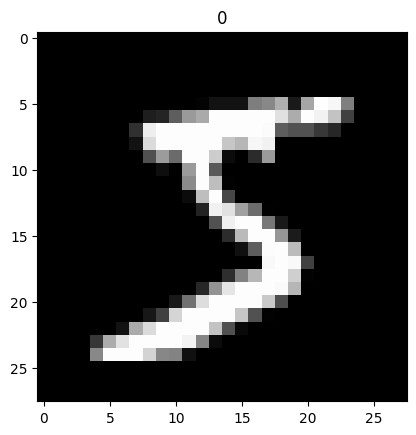

In [70]:
plt.imshow(test_image, 'gray') # 채널에 대한 정보가 없으면 흑백
plt.title(y_train[1])
plt.show()

데이터를 신경망에 넣을 준비 - 훈련, 테스트 모두 동일한 데이터의 feature의 개수를 가져야 한다.
* 신경망은 평평하게 펴진 1차원 배열을 입력으로 받고 있다.
* 즉 지금 우리가 사용할 신경망에 집어 넣을 데이터 1개의 형상은 1차원 배열 형태로 들어가야 한다.
* 평평하게 펴진 데이터를 기반으로 예측을 수행하는 레이어
  * 신경망 - Dense(Linear) Layer
  * 기하학 - Affine Layer
  * 통합적 - F.C Layer ( Fully Connected Layer ) - 전결합( 완전 연결 계층 )
------
신경망에 이미지 데이터를 입력할 수 있는 경우 확인하기
* 장수에 대한 정보 없이 가로 세로 픽셀에 대한 정보만 있는 상황 : `(28, 28)` -> X
* 장수에 대한 정보 없이 평탄화 시킨 상황 : `(784, )` -> O(일단은 허용. Tensorflow나 Pytorch 같은 머신러닝 라이브러리에서는 허용 X)
-----
`60000`장의 이미지 데이터가 `(28, 28)`인 경우. 즉 `(60000, 28, 28)`
* 장수 데이터가 있는 상태에서 가로 세로 픽셀에 대한 정보만 있는 상황 : `(60000, 28, 28)` -> X
* 장수 데이터가 있는 상태에서 평탄화 시킨 상황 : `(60000, 784)` -> O
------
입력되는 데이터의 차원이 `(N, M)`이면 신경망 F.C 레이어에 집어 넣을 수 있다.
* `N` : BATCH_SIZE( 데이터의 개수 )
* `M` : 데이터 스칼라의 개수
  * 배치를 이야기 하지 않는 경우 : `(M, )`
  * 배치를 이야기 하면 : `(N, M)`
  
**참고로 CNN은 Fully Connected Layer가 아니고, 2차원 배치 데이터를 사용하지 않기 때문에 (N, H, W, C)가 됩니다.**

In [71]:
test_image.flatten().shape #1차원 배열 형태로 바뀜

(784,)

In [72]:
test_image.reshape(-1).shape

(784,)

In [73]:
test_image.reshape(1, -1).shape # 맨 앞의 1이라는 숫자가 배치 크기를, 뒤에는 feture의 크기를 의미한다.

(1, 784)

# Fully Connected Layer 구현

In [74]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# 테스트 데이터만 가져오기
def get_test_data():
  _, (X_test, t_test) = mnist.load_data()

  # YOUR CODE HERE
  # 단순히 X_test로 리턴하는게 아닌 (N, M) 형태로 리턴하기

  IMAGE_COUNT = X_test.shape[0] # shape[0] : 이미지개수 (X_test.shape -> (10000,28,28))

  X_test_reshaped = X_test.reshape(IMAGE_COUNT, -1)

  return X_test_reshaped, t_test

# 이미 학습이 완료된 신경망 데이터 가져오기(sample_weight.pkl)
def init_network():
  import pickle
  with open("/content/drive/MyDrive/Colab Notebooks/한경_MLOps/딥러닝/data/sample_weight.pkl", "rb") as f:
    network = pickle.load(f)

  return network

In [75]:
network = init_network()
network["W1"].shape #1층의 뉴런의 개수 : 50개

(784, 50)

In [76]:
network["W2"].shape #2층의 뉴런의 개수 : 100개

(50, 100)

In [77]:
network["W3"].shape #3층의 뉴런의 개수 : 10개

(100, 10)

In [78]:
# network에 가중치가 들어있음
def predict(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']

  # 1층 구현하기
  # x : 원래 28 x 28 형식의 이미지. 이것을 평탄화 시켜 784 차원 벡터로 만듦
  # W1 : 뉴런의 개수가 몇 개인지는 몰라도
  #      입력되는 데이터의 개수인 784개의 입력을 각각 받는다는 것은 알 수 있다.

  z1 = x @ W1 + b1  # 선형 연산
  a1 = sigmoid(z1) # 활성화 함수 적용을 통한 비선형성 부여

  # 2층 구현하기
  z2 = a1 @ W2 + b2
  a2 = sigmoid(z2)

  # 출력층(3층) 구현하기
  z3 = a2 @ W3 + b3
  pred = softmax(z3) # 마지막 층(출력층)이므로, softmax 함수로 나타내기

  return pred


# 추론 과정
입력 데이터 -> 은닉층 -> 출력층
- $(N, 784)$ -> 은닉층 -> $(?, 10)$
- 결국, 레이어를 모두 통과하면, $(N, 10)$

In [79]:
X, y = get_test_data()

# 한 장의 이미지만 가져와서 테스트
test_image, test_target = X[0], y[0]

In [88]:
net = init_network()

test_result = predict(net, test_image)

<ipython-input-74-870de871762a>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [89]:
# test_result : 한 장의 이미지가 모델을 통과한 결과
# 이 모델의 결과는 softmax의 결과물임
test_result

'''
결과 값
[4.2913384e-06, 4.5766151e-07, 1.8497757e-04, 8.3665407e-05,
1.5096828e-07, 6.3233085e-07, 4.5818943e-10, 3.6787942e-01,
3.8097602e-07, 5.3097587e-04]

0번 클래스, 1번 클래스 ...n번 클래스일 확률 값 출력
'''

'\n결과 값 \n[4.2913384e-06, 4.5766151e-07, 1.8497757e-04, 8.3665407e-05,\n1.5096828e-07, 6.3233085e-07, 4.5818943e-10, 3.6787942e-01,\n3.8097602e-07, 5.3097587e-04]\n\n0번 클래스, 1번 클래스 ...n번 클래스일 확률 값 출력\n'

In [90]:
np.sum(test_result)

0.9999999

In [91]:
# 가장 확률 값이 높은 인덱스(클래스) 구해내기
# 결과 : 7 -> 7번 클래스 값이라는 뜻
np.argmax(test_result)

7

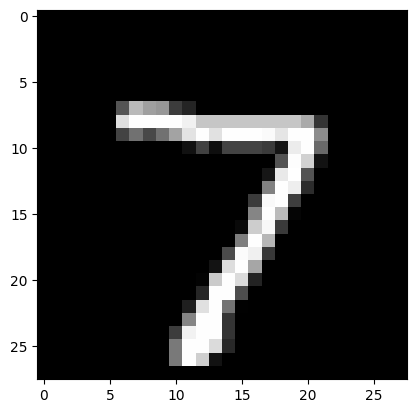

In [92]:
plt.imshow(test_image.reshape(28,28), 'gray')

# 모델의 예측 정확도 확인
- 한 장씩 예측해서 정확도 확인

In [95]:
X, y = get_test_data()

net = init_network()
acc_count = 0 # 정답을 맞춘 개수를 저장(예를 들어 1만장 중에 500장 맞았으면 500)

# 이미지를 한 장씩 꺼내서 테스트
for i in range(len(X)):
  image = X[i]

  pred = predict(net, image) # 이미지 한 장 마다의 소프트맥스 결과물 (10,)
  pred = np.argmax(pred) # 확률이 가장 높은 원소의 인덱스(예측 클래스)

  acc_count += (pred == y[i]) # 맞췄으면 acc_count에 1 더하기

float(acc_count / len(X)) # 맞춘 데이터 개수 / 전체 데이터 개수

<ipython-input-74-870de871762a>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.9207

위 코드의 단점
  * 10,000장의 이미지를 한장식 예측을 하고 있다.
  * 시간이 오래걸린다는 이야기이다.

어떻게 해결할 수 있을까?
  * **BATCH**를 사용해서 한장씩이 아닌 데이터의 묶음으로 예측을 하게 하겠다.
  * 배치 : 데이터의 뭉터기

In [97]:
# 배치를 이용한 예측
X, y = get_test_data()

net = init_network()

# 배치란? 데이터의 묶음. 정확한 명칭으로는 미니 배치
# 원래 데이터 엔지니어링 관점에서의 배치는 가지고 있는 모든 데이터를 의미
# 딥러닝 같은 머신러닝 모델링에서의 배치는 전체 데이터를 배치 사이즈 단위로 쪼갠 미니 배치를 그냥 배치라고 함

batch_size = 100
acc_count = 0

for i in range(0, len(X), batch_size):
  X_batch = X[i : i+ batch_size] # X[0 : 100] -> X[100 : 200] -> X[200 : 300]
  pred_batch = predict(net, X_batch)
  pred_batch = np.argmax(pred_batch, axis=1) #(100, 10) -> (100, 1)
                    # predict - > (100, 1) == y -> (100, 1)
  acc_count += np.sum(pred_batch == y[i : i + batch_size])

float(acc_count / len(X))


<ipython-input-74-870de871762a>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.9207